In [25]:
import pandas as pd # to load and manipulate data and for One-Hot Encoding
import numpy as np # to calculate the mean and standard deviation
import matplotlib.pyplot as plt # to draw graphs
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to draw a classification tree
from sklearn.model_selection import train_test_split # to split data into training and testing sets
from sklearn.model_selection import cross_val_score # for cross validation
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix


In [31]:
df = pd.read_csv('ricsBigData.csv')#load Dataset

if(df.columns[0]=='Unnamed: 0'):
    
    df=df.iloc[:,1:]#only use the feature and Label Colloums 
df_collumns=df.columns
df.dtypes



Rel_BreitGross     float64
RelSpitze_oben     float64
RelSpitze_unten    float64
Anzahl_Linie         int64
Anzahl_Ecken         int64
Anzahl_Kreis         int64
Label                int64
dtype: object

In [41]:
# shows the count of differnt classes
df[df_collumns[-1]].unique()



array([0, 1, 2], dtype=int64)

In [39]:
#show if there are any missing values to worry about 
for member in df_collumns: 
    print("missing values",member,":",len(df.loc[(df[member]=='?')]))


missing values Rel_BreitGross : 0
missing values RelSpitze_oben : 0
missing values RelSpitze_unten : 0
missing values Anzahl_Linie : 0
missing values Anzahl_Ecken : 0
missing values Anzahl_Kreis : 0
missing values Label : 0


In [42]:
X=df.iloc[:,:-1]#selct all features 
X.head()



,Rel_BreitGross,RelSpitze_oben,RelSpitze_unten,Anzahl_Linie,Anzahl_Ecken,Anzahl_Kreis
0,0.291153,0.009050,0.651584,9,2,0
1,0.338341,0.556122,0.750000,10,5,0
2,0.726178,0.985294,0.989496,6,8,0
3,0.316422,0.738397,0.616034,27,15,0
4,0.260098,0.175510,0.640816,15,8,0


In [43]:
Y=df.iloc[:,-1]#select the Labels for the diffrent classes
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: Label, dtype: int64

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [46]:
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)


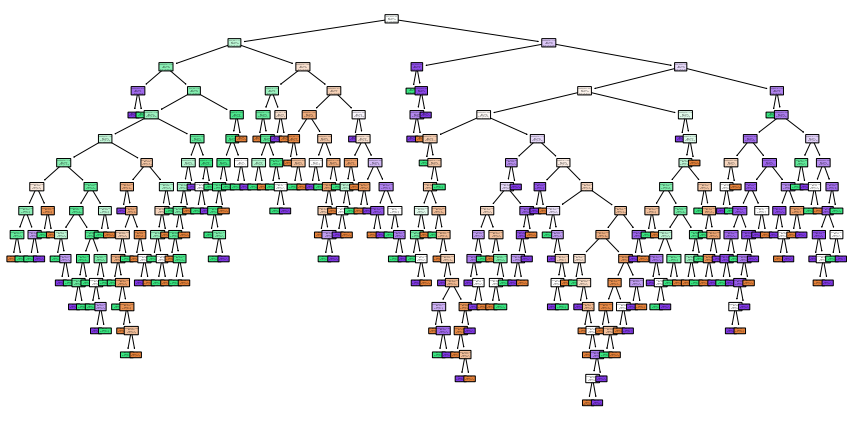

In [52]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["Dosenoeffner", "Falschenoeffner", "Korkenzieher"], 
          feature_names=df_collumns); 

c:\Users\jonas\Documents\08_Master\Python_Projekte\Verfahren_der_KI\KIProjekt\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


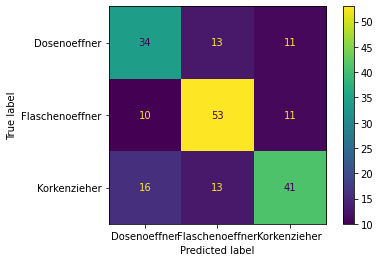

In [53]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["Dosenoeffner", "Flaschenoeffner","Korkenzieher"])

In [55]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas # extract different values for alpha
ccp_alphas = ccp_alphas[:-1] # exclude the maximum value for alpha
clf_dts = [] # create an array that we will put decision trees into

In [56]:
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)


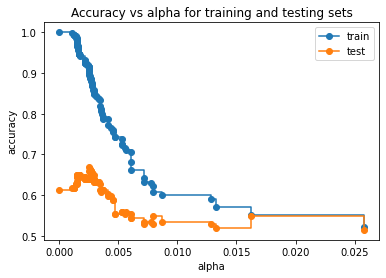

In [57]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()


<AxesSubplot:xlabel='tree'>

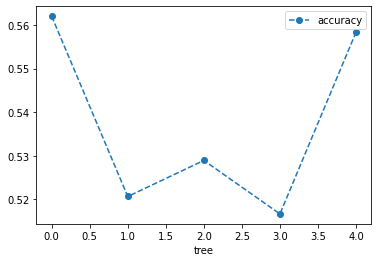

In [58]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.016) # create the tree with ccp_alpha=0.016

## now use 5-fold cross validation create 5 different training and testing datasets that
## are then used to train and test the tree.
## NOTE: We use 5-fold because we don't have tons of data...
scores = cross_val_score(clf_dt, X_train, y_train, cv=5) 
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

<AxesSubplot:xlabel='alpha'>

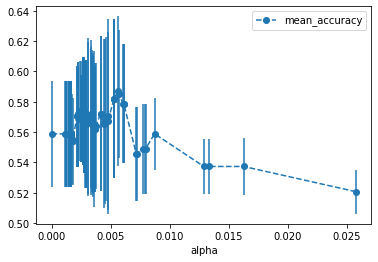

In [59]:
alpha_loop_values = []

## For each candidate value for alpha, we will run 5-fold cross validation.
## Then we will store the mean and standard deviation of the scores (the accuracy) for each call
## to cross_val_score in alpha_loop_values...
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

## Now we can draw a graph of the means and standard deviations of the scores
## for each candidate value for alpha
alpha_results = pd.DataFrame(alpha_loop_values, 
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha', 
                   y='mean_accuracy', 
                   yerr='std', 
                   marker='o', 
                   linestyle='--')

In [68]:
alpha_results[(alpha_results['alpha'] > 0.014)
              &
              (alpha_results['alpha'] < 0.015)]


# Now let's store the ideal value for alpha so that we can use it to build the best tree.

# In[ ]:


ideal_ccp_alpha = alpha_results[(alpha_results['alpha'] > 0.014) 
                                & 
                                (alpha_results['alpha'] < 0.015)]['alpha']
ideal_ccp_alpha


# **NOTE:** At this point Python thinks that `ideal_ccp_alpha` is a `series`, which is a type of array. We can tell because when we printed `ideal_ccp_alpha` out, we got two bits of stuff. The first one was `20`, which is the index in the series, the second one, `0.014225`, is the value we want. So we can convert this from a series to a float with the following command:

# In[ ]:


## convert ideal_ccp_alpha from a series to a float
#ideal_ccp_alpha[alpha_results['alpha']].apply(lambda x: float(x))
ideal_ccp_alpha=ideal_ccp_alpha.astype(float)
#ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha


Series([], Name: alpha, dtype: float64)

In [69]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42, 
                                       ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train) 


# Now let's draw another confusion matrix to see if the pruned tree does better.

# In[ ]:


plot_confusion_matrix(clf_dt_pruned, 
                      X_test, 
                      y_test, 
                      display_labels=["Does not have HD", "Has HD"])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [63]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt_pruned, 
          filled=True, 
          rounded=True, 
          class_names=["No HD", "Yes HD"], 
          feature_names=X_encoded.columns); 

NameError: name 'X_encoded' is not defined

<Figure size 1080x540 with 0 Axes>